In [ ]:
import yfinance as yf


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Data collection from yahoo finance (USD -> LKR)
usd_lkr = yf.download('USDLKR=X', start='2025-01-01', end='2025-12-31', interval="1wk")
usd_lkr.reset_index(inplace=True)
usd_lkr = usd_lkr[['Date','Close']]
usd_lkr.columns = ['Date', 'USD_LKR']

/tmp/ipython-input-332/1805668464.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  usd_lkr = yf.download('USDLKR=X', start='2025-01-01', end='2025-12-31', interval="1wk")
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Gold Data collection from yahoo finance (USD per ounce)
gold_usd = yf.download('GC=F', start='2025-01-01', end='2025-12-31', interval='1wk')
gold_usd.reset_index(inplace=True)
gold_usd = gold_usd[['Date','Close']]
gold_usd.columns = ['Date', 'Gold_USD']

/tmp/ipython-input-332/17747053.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_usd = yf.download('GC=F', start='2025-01-01', end='2025-12-31', interval='1wk')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Merge both datasets on Date
df = gold_usd.merge(usd_lkr, on='Date', how='inner')

In [ ]:
# Convert Gold USD/oz to LKR/gram
df['Gold_LKR_per_gram'] = (df['Gold_USD'] / 31.1035) * df['USD_LKR']

In [ ]:
# View sample
print(df[['Date', 'Gold_USD', 'USD_LKR', 'Gold_LKR_per_gram']].head())

        Date     Gold_USD     USD_LKR  Gold_LKR_per_gram
0 2025-01-01  2656.699951  292.630676       24994.997455
1 2025-01-08  2677.500000  291.400726       25084.811829
2 2025-01-15  2755.000000  293.620911       26007.542843
3 2025-01-22  2766.800049  295.187225       26258.267703
4 2025-01-29  2853.300049  293.446228       26919.482912


In [ ]:
# Drop Gold_USD if not needed
df.drop(columns=['Gold_USD'], inplace=True)

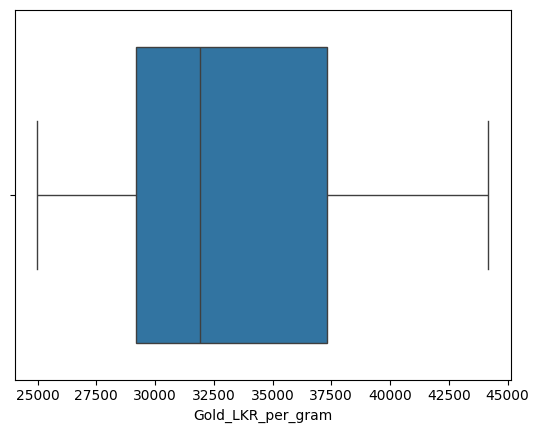

In [ ]:
# Boxplots
sns.boxplot(x=df['Gold_LKR_per_gram'])
plt.show()

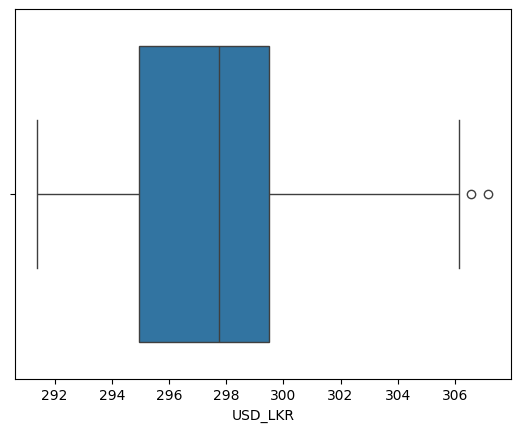

In [ ]:
sns.boxplot(x=df['USD_LKR'])
plt.show()

In [ ]:
# Check max and min
print("USD_LKR max:", df['USD_LKR'].max())
print("USD_LKR min:", df['USD_LKR'].min())

USD_LKR max: 307.1670837402344
USD_LKR min: 291.4007263183594


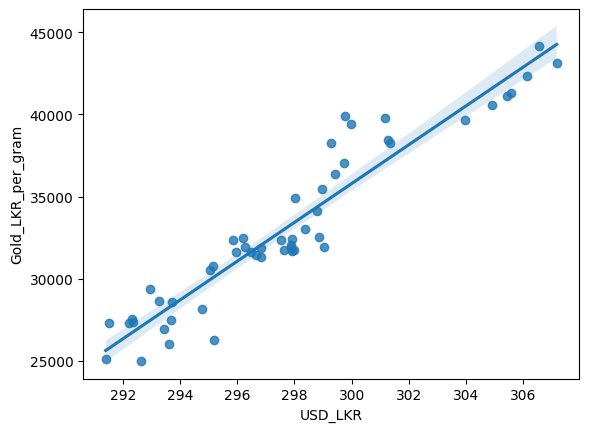

In [ ]:
# Regression plot
sns.regplot(x=df['USD_LKR'], y=df['Gold_LKR_per_gram'])
plt.show()


In [ ]:
# Prepare X and y (as DataFrames)
x = df[['USD_LKR']]
y = df[['Gold_LKR_per_gram']]

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

print("Shapes:", x_train.shape, x_test.shape, y_train.shape, y_test.shape)


Shapes: (46, 1) (6, 1) (46, 1) (6, 1)


In [ ]:
# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [ ]:
# Linear Regression model
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train_scaled, y_train)


LinearRegression()

In [ ]:
# Model parameters
m = regressor.coef_[0][0]
b = regressor.intercept_[0]
print("m:", m, "b:", b)

m: 4760.825440125492 b: 32946.748133729954


In [ ]:
# Predictions on TRAIN (for plotting fit)
x_train_predict = regressor.predict(x_train_scaled)

In [ ]:
# Sort for clean line plot
idx = np.argsort(x_train.values.reshape(-1))
x_sorted = x_train.values.reshape(-1)[idx]
y_pred_sorted = x_train_predict.reshape(-1)[idx]

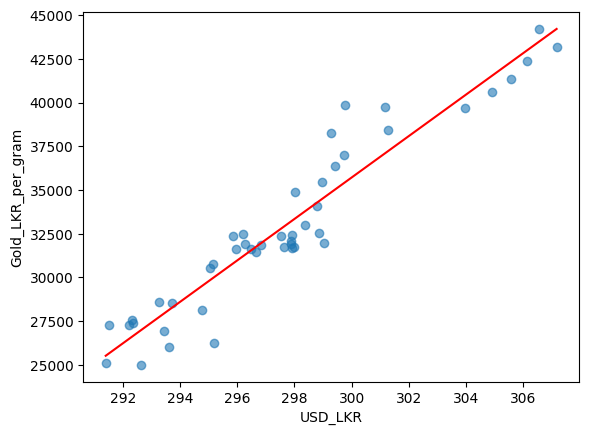

In [ ]:
# Plot training data + regression line
plt.scatter(x_train, y_train, alpha=0.6)
plt.plot(x_sorted, y_pred_sorted, color='red')
plt.xlabel('USD_LKR')
plt.ylabel('Gold_LKR_per_gram')
plt.show()


In [ ]:
x_test_predicted = regressor.predict(x_test_scaled)

In [ ]:
x_test_predicted

array([[31954.48714272],
       [35678.11106144],
       [42152.72034318],
       [27351.38581547],
       [37322.08874228],
       [28208.25129507]])

In [ ]:
y_test

,Gold_LKR_per_gram
19,31304.779720
41,39422.801609
47,41111.739405
12,29375.149484
43,38248.610856
5,27498.866076


MLops

In [ ]:
import pickle # To save all the data in byte count

In [ ]:
pickle.dump(regressor, open('regressor.pkl', 'wb'))

In [ ]:
regressor_reloaded = pickle.load(open('regressor.pkl', 'rb'))

In [ ]:
regressor_reloaded.coef_

array([[4760.82544013]])

In [ ]:
pickle.dump(regressor, open('scaler.pkl', 'wb'))

In [ ]:
def calculate_gold_rate(usd_lkr):
    scaled_input = scaler.transform(np.array(usd_lkr).reshape(1, -1))
    prediction = regressor.predict(scaled_input)[0][0]
    return round(float(prediction), 2)

In [ ]:
import gradio as gr
demo = gr.Interface(
    fn=calculate_gold_rate,
    inputs=gr.Number(label="USD Price Today"),
    outputs=gr.Number(label="Predicted Gold Price (LKR per gram)")
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b55d559995a8b3b12c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
